# Credit Risk Modelling
Author: Sam Steinberg, Computer Science Graduate Student at Arizona State University

Abstract
The goal of this project was to create a program that takes in information about a loan applicant, evaluates their credit risk and outputs whether the bank should approve the loan or not. I ran multiple classification models, eventually tuning a SVM classifier that had a 76% accuracy rate. Finally, I created a simple program that outputs whether the bank should approve a loan for a new applicant. 

## Step 1- Data Preprocessing

Loading Libraries

In [450]:
import pandas as pd #Dataset Manipulation
import numpy as np #Math
import seaborn as sns #Graphing library
import matplotlib.pyplot as plt #Visualization
import matplotlib.style as style
style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
#Dataset Source: https://www.kaggle.com/marcelotc/german-credit-risk

Loading Dataset 

In [451]:
df = pd.read_csv('german_credit.csv')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
Creditability                        1000 non-null int64
Account Balance                      1000 non-null int64
Duration of Credit (month)           1000 non-null int64
Payment Status of Previous Credit    1000 non-null int64
Purpose                              1000 non-null int64
Credit Amount                        1000 non-null int64
Value Savings/Stocks                 1000 non-null int64
Length of current employment         1000 non-null int64
Instalment per cent                  1000 non-null int64
Sex & Marital Status                 1000 non-null int64
Guarantors                           1000 non-null int64
Duration in Current address          1000 non-null int64
Most valuable available asset        1000 non-null int64
Age (years)                          1000 non-null int64
Concurrent Credits                   1000 non-null int64
Type of apartment                    10

Getting rid of columns with N/A and missing values

In [452]:
df = df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
#Dropping "id" and "member_id" columns since they are useless to the model
df = df.drop(df.columns[[18,19]], axis = 1, inplace = False)
df

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,1
1,1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,1
2,1,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,1
3,1,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,2
4,1,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,1,24,2,3,1987,1,3,2,3,1,4,1,21,3,1,1,2,1
996,0,1,24,2,0,2303,1,5,4,3,2,1,1,45,3,2,1,3,1
997,0,4,21,4,0,12680,5,5,4,3,1,4,4,30,3,3,1,4,1
998,0,2,12,2,3,6468,5,1,2,3,1,1,4,52,3,2,1,4,1


Exploring Variables

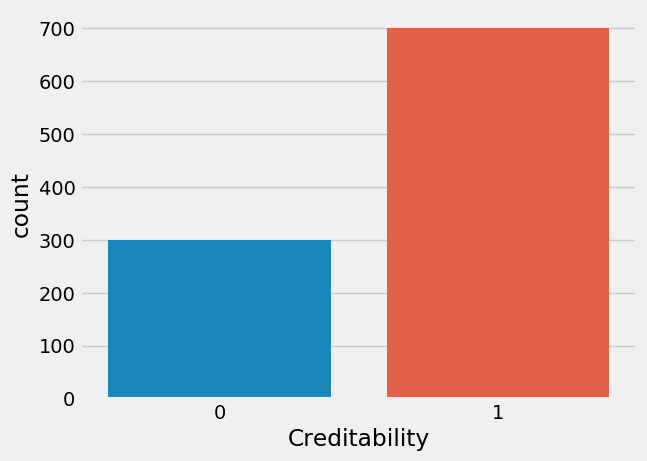

In [453]:
sns.countplot(x = "Creditability", data = df)
plt.show()

Since only 30% of customers do not have credibility, I will make class weights balanced in the model.

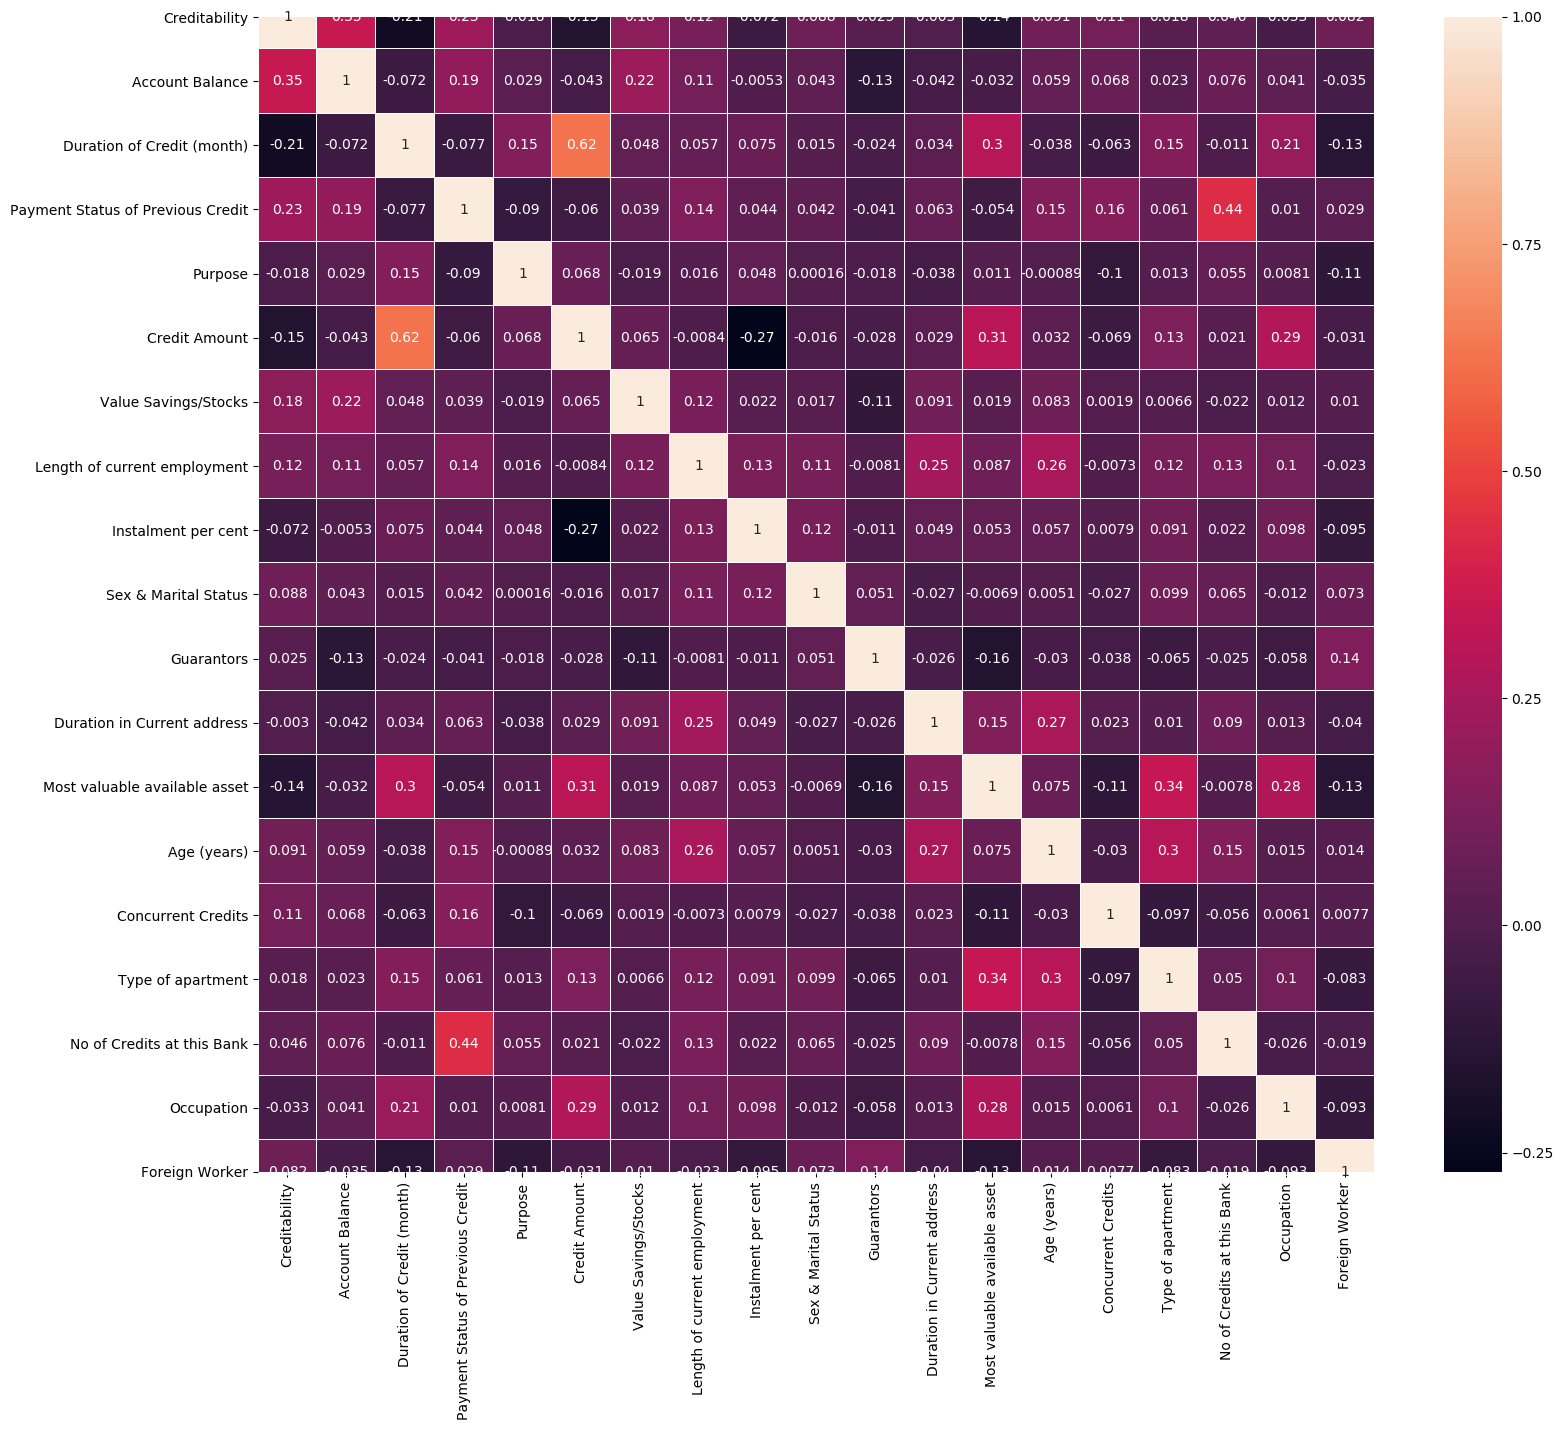

In [454]:
style.use('default')
plt.figure(figsize = (18,15))
sns.heatmap(df.corr(), linewidth= 0.01, annot = True)
plt.show()

No variables correlate with one another besides "Duration of Credit" and "Credit Amount." This means little to no multicollinearity exists.

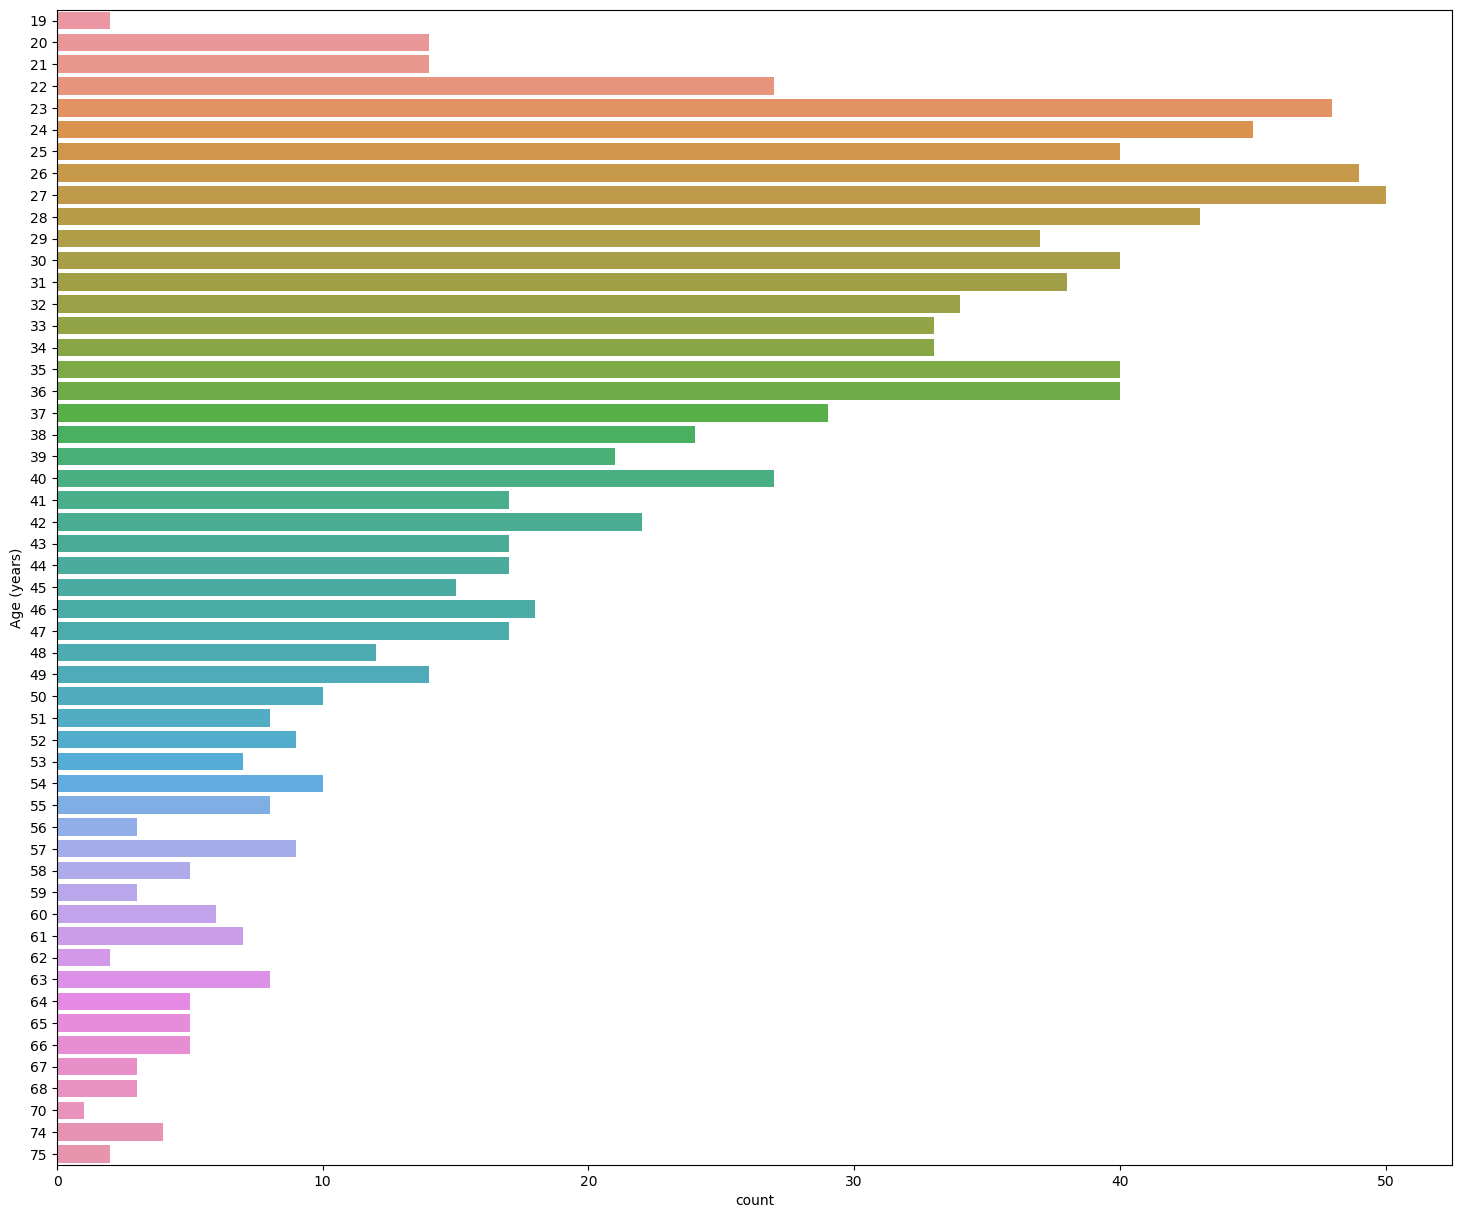

In [455]:
plt.figure(figsize = (18,15))
sns.countplot(y = "Age (years)", data = df)
plt.show()

Most of the people applying for loans are less than 45 years of age, hence this model will be more accurate for younger individuals.  

Splitting Dataset into dependent and independent variables

In [456]:
x = df.iloc[:,1:19].values #Independent variables
y = df.iloc[:,0].values #Dependent variable 
x

array([[ 1, 18,  4, ...,  1,  3,  1],
       [ 1,  9,  4, ...,  2,  3,  1],
       [ 2, 12,  2, ...,  1,  2,  1],
       ...,
       [ 4, 21,  4, ...,  1,  4,  1],
       [ 2, 12,  2, ...,  1,  4,  1],
       [ 1, 30,  2, ...,  1,  3,  1]])

Splitting Data into training and test sets

In [457]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.20, random_state = 0) #Test size of 20% gives best results for this model
x

array([[ 1, 18,  4, ...,  1,  3,  1],
       [ 1,  9,  4, ...,  2,  3,  1],
       [ 2, 12,  2, ...,  1,  2,  1],
       ...,
       [ 4, 21,  4, ...,  1,  4,  1],
       [ 2, 12,  2, ...,  1,  4,  1],
       [ 1, 30,  2, ...,  1,  3,  1]])

Feature Scaling our variables so they are normalized for the model

In [458]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Step 2- Comparing Algorithms

In [459]:
from sklearn.model_selection import KFold, cross_val_score # to split the data
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, fbeta_score #To evaluate our model
from sklearn.model_selection import GridSearchCV

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

Fitting data on multiple classification models to see which one gives the best results.

In [460]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))

Evaluating each model. We use recall as our primary evaluation metric since we want to avoid lending out a loan to someone who is credible but in reality is not (False Negative). This is better than a False Positive, where we don't lend a loan out to someone who is not credible when in reality they are.

LR: 0.882765 (0.042299)
LDA: 0.883856 (0.047044)
KNN: 0.866531 (0.050513)
CART: 0.756955 (0.038131)
NB: 0.744955 (0.034733)
RF: 0.824694 (0.036388)
SVM: 0.908378 (0.041615)


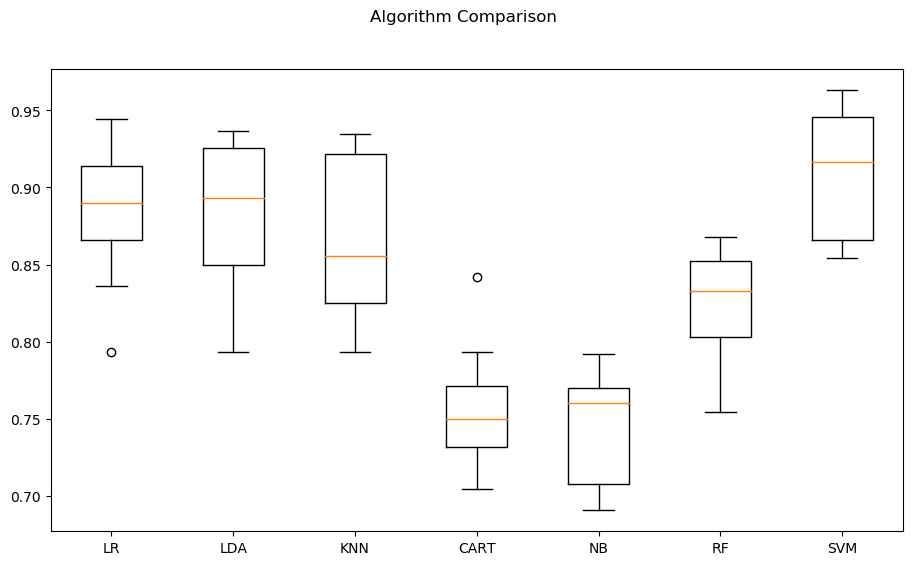

In [461]:
results = []
names = []
scoring = 'recall' 
seed = 1

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, x_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

- SVM and KNN had the highest cross validation scores, so I will further investigate these two algorithms to see which one gives the best results. 

## Step 3- Evaluating Models

### 1) SVM

Evaluating Model

In [462]:
param_grid = {"gamma":['scale', 'auto'],
              "kernel":['sigmoid'],
              "class_weight":['balanced'],
             } 

grid_search = GridSearchCV(SVC(), param_grid=param_grid, refit = True, scoring = 'recall', verbose = 0) 
grid_search.fit(x_train, y_train)

print("Best Score: " + str(grid_search.best_score_))
print("Best Parameters: " + str(grid_search.best_params_))

svm_grid_pred = grid_search.predict(x_test) 

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,svm_grid_pred))
print(classification_report(y_test, svm_grid_pred)) 

Best Score: 0.6813713450292397
Best Parameters: {'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'sigmoid'}
[[52 16]
 [39 93]]
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        68
           1       0.85      0.70      0.77       132

    accuracy                           0.73       200
   macro avg       0.71      0.73      0.71       200
weighted avg       0.76      0.72      0.73       200



### 2) KNN 

In [463]:
param_grid = {"n_neighbors": [25,25,30,31,32,33,34,35,40],
              "weights": ['uniform', 'distance'],
              "algorithm": ['auto','ball_tree', 'kd_tree', 'brute'],
               "leaf_size": [10,11,12,13,14,15,20,25]} 

grid_search = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, refit = True, scoring = 'recall', verbose = 0) 
grid_search.fit(x_train, y_train)

print("Best Score: " + str(grid_search.best_score_))
print("Best Parameters: " + str(grid_search.best_params_))

knn_grid_pred = grid_search.predict(x_test) 

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,knn_grid_pred))
print(classification_report(y_test, knn_grid_pred)) 

Best Score: 0.9665701754385965
Best Parameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 40, 'weights': 'distance'}
[[ 14  54]
 [  3 129]]
              precision    recall  f1-score   support

           0       0.82      0.21      0.33        68
           1       0.70      0.98      0.82       132

    accuracy                           0.71       200
   macro avg       0.76      0.59      0.57       200
weighted avg       0.75      0.71      0.65       200



Adjusting parameters further to get best knn model

In [ ]:
knn_model = KNeighborsClassifier(algorithm= 'auto', leaf_size= 14, n_neighbors= 25, weights= 'distance')
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)
print(classification_report(y_test,y_pred))

- SVM outputs a much higher recall for customer who don't qualify for a loan (76% vs 31% for KNN). Therefore, we will use the SVM classifier to model our data. This score is important since we do not want to hand out a loan to a person who has high credit risk. If the model makes a mistake, we would rather it reject a customer who has low credit risk. 

## Step 4- Evaluating and Tuning Final Model

Refitting our model to SVM using best parameters. 

In [465]:
svm_model = SVC(kernel='sigmoid', random_state = 1, class_weight = 'balanced', coef0 =0.0)
svm_model.fit(x_train, y_train)
y_pred = svm_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.57      0.76      0.65        68
           1       0.85      0.70      0.77       132

    accuracy                           0.73       200
   macro avg       0.71      0.73      0.71       200
weighted avg       0.76      0.72      0.73       200



- Our best recall score is 0.76. This means our model is correctly predicting a false negative 76% of the time. 

### Plotting AUC Graph
Another tool in evaluating model performance is using an AUC graph. The closer the line gets to y=1, the more accurate the model is. Our AUC score is .73. AUC scores vary from 0 to 1, with 0.5 being a poor model and 1 being a perfect model. Our model is respectable (AUC > .70).

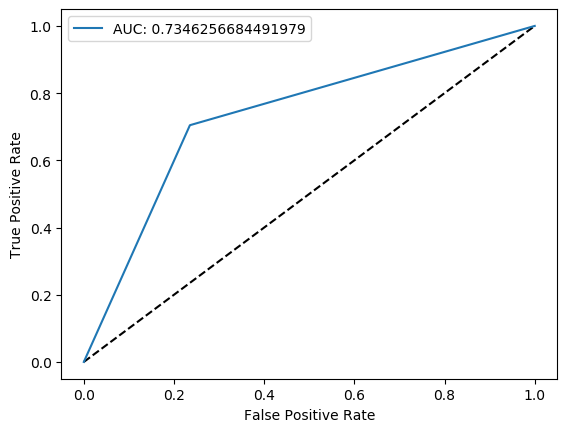

In [466]:
#Visualizing Results with AUC Graph in order to evaluate model performance
style.use("default")
from sklearn.metrics import roc_curve, auc
fpr,tpr,threshold = roc_curve(y_test, y_pred)
auc = auc(fpr,tpr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr, label = 'AUC: ' + str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Credit Risk Program

### INSTRUCTIONS:
Pretend you are entering information about a potential new customer into a software application that will detect whether that customer is eligble for a loan or not. Run this file in Jupyter Notebook, enter all information in integer format (whole numbers, no decimals), then click the "Submit" button. Non-integer variables and decimal numbers have been categorized into integer values. Here is the link where you can see which number (score) to enter for a specific variable: https://online.stat.psu.edu/stat508/book/export/html/803

- All information must be integers (whole numbers, no decimals)
- In case of error or missed input, reset the kernel (press the square button at the top of Jupyter Notebook next to the "Run" button), click "Cell" and then "Run All." Wait for program to run again and re-enter input.
   

In [467]:
#Importing Libraries
import ipywidgets as widgets
from ipywidgets.widgets import Label, Button, Layout, HBox, VBox, Text
from IPython.display import display
import threading
from ipywidgets import interact, interactive, fixed, interact_manual
import time

In [ ]:
#GUI Components
qNum = 1
answers = []

def submit(greeting):
        answers.append(textbox.value)
        print("Answers List: ")
        print(answers)
        
df = df.drop(df.columns[0], axis = 1, inplace = False)

for col_name in df.columns:
    answers.append(input(str(qNum) + ') Enter ' + str(col_name) + ' and Press "Enter": '))
    qNum = qNum + 1
    print(answers)
   
b = Button(
    description = 'Submit',
    button_style = 'warning',
    layout = Layout(width = '100px')
           )
display(b)

#Logic 
def on_button_clicked(x):
    #customer_df = DataFrame(np.array(answers).reshape(1,18),columns=[df.iloc[0,0:19]])
    customer_df = pd.DataFrame(np.array(answers).reshape(-1, len(answers)),columns= df.columns)
    x_test = customer_df.iloc[:,:].values
    print(x_test)
    scaler2 = StandardScaler()
    x_test = scaler2.fit_transform(x_test)
    y_pred = svm_model.predict(x_test)
    print("Your responses: " + str(y_pred))

    evaluation = list(map(int, y_pred)) 
    if(evaluation[0] == 1):
        print('Our model indicates this customer has low credit risk and IS eligible for a loan.')
    else:
        print('Our model indicates this customer has high credit risk and IS NOT eligible for a loan. ')
    
b.on_click(on_button_clicked)

## Conclusion


The goal of this project was to identify clients who did and did not quality for a loan. I compared multiple classification models in order to find the most accurate one for the dataset. My model was able to accurately predict a false negative 76% of customers who did not quality for a loan. These are respectable scores but could improve with a larger dataset. In addition, I found this model is most accurate for customers less than 45 years of age. This model can help conclude whether a bank gives a new customer a loan or not. In addition, I created a demo program that takes in input about a new client and outputs a result.